In [ ]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_csv('data/maindata.csv', dtype={'price_string_unf': 'object'})

# Dask is faster for larger datasets but it doesnt show inline output, so i've not used it here
daskdf = dd.read_csv('data/maindata.csv', dtype={'price_string_unf': 'object'})

In [ ]:
df.shape

In [ ]:
df.describe()

## *Question 1*
Products without prices

In [ ]:
df.head()

In [ ]:
# Faster, just count
df['price_string'].isna().value_counts()

In [ ]:
# Slower, returns data. This df has all products without price_string
noprices = df[df['price_string'].isna()]
noprices.shape

### There are 8,220,000 products without prices
All products without price are stored in noprices.

In [130]:
num_hasprices = df.shape[0]
num_noprices = noprices.shape[0]

Text(0.5, 1.0, 'Number of products with and without prices')

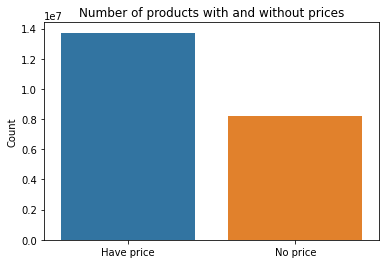

In [134]:
sns.barplot(y=[num_hasprices, num_noprices], x=['Have price', 'No price'])
plt.ylabel('Count')
plt.title("Number of products with and without prices")

## *Question 2*
Count of products without prices and with prices in each Product Type, Category,
Level 1

### Product Type

In [ ]:
# Entire dataframe grouped by product type
grpby_prodtype = df.groupby('product_type')

321

In [170]:
# Number of products which have a price, grouped by product type
hasprice_prodtype = grpby_prodtype.count()
hasprice_prodtype.rename(columns={"price_string": "hasprice"}, inplace=True)
hasprice_prodtype.hasprice

product_type
Q0FUIExJVFRFUg                                  0
Q29mZmVlIEJlYW5z                            30000
Q29mZmVlIEZpbHRlcnM                             0
Q29uZGl0aW9uZXIgSGFpcg                      10000
Q29va2llcw                                      0
                                            ...  
cGV0IEJsYW5rZXQ                             10000
cGV0IFN0YWluIGFuZCBvZG9yIGVsaW1pbmF0b3I         0
d29tZW5zIE91dGVyd2Vhcg                     130000
d29tZW5zIFdhbGxldA                          20000
d29tZW5zIHN3ZWF0ZXJz                        30000
Name: hasprice, Length: 321, dtype: int64

In [171]:
# Number of products which dont have a price, grouped by product type
totalsize_prodtype = grpby_prodtype.size()
noprice_prodtype = totalsize_prodtype - hasprice_prodtype.hasprice
noprice_prodtype

product_type
Q0FUIExJVFRFUg                             30000
Q29mZmVlIEJlYW5z                           50000
Q29mZmVlIEZpbHRlcnM                        10000
Q29uZGl0aW9uZXIgSGFpcg                     20000
Q29va2llcw                                 30000
                                           ...  
cGV0IEJsYW5rZXQ                            10000
cGV0IFN0YWluIGFuZCBvZG9yIGVsaW1pbmF0b3I    10000
d29tZW5zIE91dGVyd2Vhcg                     20000
d29tZW5zIFdhbGxldA                         10000
d29tZW5zIHN3ZWF0ZXJz                       90000
Length: 321, dtype: int64

In [198]:
bruh = pd.DataFrame(grpby_prodtype.groups.keys(), columns=['product_type'])
bruh.set_index(['product_type'])
# bruh.shape
bruh['hasprice'] = hasprice_prodtype.hasprice.values
bruh['noprice'] = noprice_prodtype.values

In [199]:
bruh

,product_type,hasprice,noprice
0,Q0FUIExJVFRFUg,0,30000
1,Q29mZmVlIEJlYW5z,30000,50000
2,Q29mZmVlIEZpbHRlcnM,0,10000
3,Q29uZGl0aW9uZXIgSGFpcg,10000,20000
4,Q29va2llcw,0,30000
...,...,...,...
316,cGV0IEJsYW5rZXQ,10000,10000
317,cGV0IFN0YWluIGFuZCBvZG9yIGVsaW1pbmF0b3I,0,10000
318,d29tZW5zIE91dGVyd2Vhcg,130000,20000
319,d29tZW5zIFdhbGxldA,20000,10000


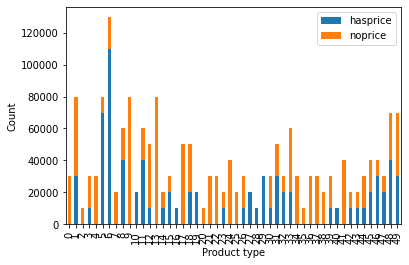

In [202]:
#
# sns.barplot(x=bruh.product_type, y=[bruh.hasprice, bruh.noprice], stacked=True)
bruh[:50].plot(kind='bar', stacked=True)
plt.xticks(rotation=90)
plt.xlabel('Product type')
plt.ylabel('Count')
plt.show()

### Category

In [ ]:
# Entire dataframe grouped by category
grpby_category = df.groupby('category')

In [ ]:
# Number of products which have a price, grouped by category
hasprice_category = df.groupby('category').count()
hasprice_category.rename(columns={"price_string": "hasprice"}, inplace=True)
hasprice_category.hasprice

In [ ]:
# Number of products which dont have a price, grouped by category
totalsize_category = grpby_category.size()
noprice_category =  totalsize_category- hasprice_category.hasprice
noprice_category

### Level 1


In [ ]:
# Entire dataframe grouped by level1
grpby_level1 = df.groupby('level_1')


In [ ]:
# Number of products which have a price, grouped by level1
hasprice_level1 = df.groupby('level_1').count()
hasprice_level1.rename(columns={"price_string": "hasprice"}, inplace=True)
hasprice_level1.hasprice

In [ ]:
# Number of products which dont have a price, grouped by level1
totalsize_level1 = grpby_level1.size()
noprice_level1 = totalsize_level1 - hasprice_level1.hasprice
noprice_level1

## *Question 3*
Correct Product Prices in the correct format (eg: $56) wherever possible and
separate them into currency and value columns

In [ ]:
df_with_prices = pd.DataFrame(df['price_string'].dropna())

In [ ]:
# function that converts non-null string values to a $ddd format (d is a digit). If null, returns NaN

def add_doll(price):
    if pd.isnull(price):
        return np.nan
    else:
        if str(price)[0]!='$':
            return '$'+str(price)
        return str(price)

In [ ]:
# df_with_prices['price'] = df_with_prices['price_string'].apply(add_doll)

In [ ]:
value_df = df.copy()

# Here we drop all NaN values in the price column, but can comment this out if needed

value_df = value_df[value_df['price_string'].notna()]

In [ ]:
value_df['currency'] = value_df['price_string'].apply(add_doll)
value_df['value'] = value_df['currency'].apply(lambda x: float(str(x).replace('$', '')))

In [ ]:
# This is the original dataframe with columns for currency and value, as per the given instructions
value_df.head()

In [ ]:
# Condition that checks if a value has a $ anywhere except the start
regex_flag = df['price_string'].str.contains('\d+\$\d*')

In [ ]:
# if there isnt a $, the flag stores NaN. This replaces NaN with false so we can use it as a condition
tempe = regex_flag.fillna(False)

In [ ]:
# Returns all rows where $ is present apart from the [0]th position.
# No rows are returned, which means all rows are either in $ddd or ddd format
# This was just to see if my replacement logic was valid
df[tempe]

In [ ]:
# The following lines were for a differently shaped dataframe

# df_with_prices['value'] = df_with_prices['price'].apply(lambda x: x.replace('$', ''))
# df_with_prices
# TODO: Do this with main dataset

## Question 4
List out the categories with average price of product.

In [ ]:
# Create a dataframe that has only categories and price values
category_df = value_df[['category', 'value']].copy()
category_df.head()


In [ ]:
value_grpby_category = category_df.groupby('category')
avg_price_by_category = value_grpby_category.mean()
avg_price_by_category.rename(columns={'value': 'average_price'}, inplace=True)

In [ ]:
# Dataframe with average price of products by category
avg_price_by_category

In [ ]:
# Plotting the avg price per category. Truncated category name to 10 letters to maintain readability. 
# (not like the category names are readable in any case)

sns.barplot(x=avg_price_by_category.index.str.slice(0,10),y=avg_price_by_category.average_price)
plt.xticks(rotation=45)
plt.show()